# Risk-Return Optimized Portfolio Construction and Risk Management


### Structure

- Locate the tangency portfolio of stocks in stock_pool using mean-variance analysis
- Find out how much the tangency portfolio is exposed to Market Factor, Size Factor, and Value Factor (Fama-French Three-Factor Model)
- Evaluate the tangency portfolio performance and risk (Tracking Error, Information Value, Maximum Drawdown, Value at Risk, Expected Shortfall)

### Conclusion
- The optimal weights for ['AAPL', 'KR', 'LAC', 'V'] is [30%, 43%, 27%, 0%]
- The tangency portfolio is mainly exposed to market factor and size factor 
- The tangency portfolio has positive tracking error and information value, daily VaR at 95% confidence level is estimated as -0.035

In [1]:
# pip install pandas_datareader
import pandas_datareader.data as web
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import minimize
import statsmodels.formula.api as smf
import urllib.request
import zipfile
from scipy.stats import norm

## I Locate the Tangency Portfolio

### 1. Prepare Data

In [2]:
# define start and end time
start = datetime.datetime(2020,1,1)
end = datetime.datetime(2021,10,29)

# stocks have been pre-selected using a top-down approach and tickers are stored in list "stock_pool"
stock_pool = ['AAPL','KR','LAC','V']

# get data from Yahoo Finance
def getdata(ticker):
    stockprice = web.DataReader(ticker,'yahoo',start,end)
    return stockprice

stocks = pd.DataFrame()
for ticker in stock_pool:
    stockprice = getdata(ticker)
    # consider the adjusted closing price more accuarate (than closing price) to reflect the true value of the stock 
    stockprice = stockprice['Adj Close']
    stocks = pd.concat([stocks,stockprice], axis=1)
stocks.columns = stock_pool

# check the beginning and end of dataset
stocks.iloc[np.r_[0:5,-5:0]]

,AAPL,KR,LAC,V
2020-01-02 00:00:00,73.988472,27.500257,3.300000,188.791092
2020-01-03 00:00:00,73.269150,27.538639,3.520000,187.289627
2020-01-06 00:00:00,73.852982,27.634588,3.630000,186.884613
2020-01-07 00:00:00,73.505646,27.433088,3.630000,186.390717
2020-01-08 00:00:00,74.688072,27.269968,3.510000,189.581329
2021-10-25 00:00:00,148.423386,40.129639,26.650000,233.469009
2021-10-26 00:00:00,149.102402,39.761475,27.459999,231.412628
2021-10-27 00:00:00,148.633087,39.283859,26.420000,215.400803
2021-10-28 00:00:00,152.347656,39.492817,27.879999,209.471237
2021-10-29 00:00:00,149.581696,39.821178,29.020000,211.397858


### 2. Return vs Volatility Chart

In [3]:
# log returns promote fairness among stocks trading at different price levels; besides, log returns is time additive
returns = stocks/stocks.shift(1)
logreturns = np.log(returns) 

# set 10-Y treasury yield as of 2021-10-29 as risk-free rate (annualized 1.5570%)
Annual_RiskfreeRate = 0.015570
RiskfreeRate = ((1+Annual_RiskfreeRate)**(1/252))-1

# get log returns, volatility, and Sharpe Ratio for each stock in stock pool
mean_logreturns = logreturns.mean()
std_logreturns = logreturns.std()
SR = (mean_logreturns-RiskfreeRate)/std_logreturns
stocks_performance = pd.concat([mean_logreturns, std_logreturns, SR], axis=1)
stocks_performance.columns = ['mean_logreturns', 'std_logreturns', 'SR']
stocks_performance

,mean_logreturns,std_logreturns,SR
AAPL,0.001527,0.024170,0.060640
KR,0.000803,0.019342,0.038349
LAC,0.004716,0.060535,0.076892
V,0.000245,0.022125,0.008318


In [4]:
# calculate expected log returns, expected volatility, and SR for each portfolio
number_of_portfolios = 10000
number_of_stocks = len(stock_pool)
weight = np.zeros((number_of_portfolios,number_of_stocks))
expected_return = np.zeros(number_of_portfolios)
expected_volatility = np.zeros(number_of_portfolios)
SharpeRatio = np.zeros(number_of_portfolios)
mean_logreturns = logreturns.mean()
sigma_logreturns = logreturns.cov()

for k in range(number_of_portfolios):
    # generate random weight vector
    w = np.array(np.random.random(number_of_stocks))
    w = w/np.sum(w)
    weight[k,:] = w
    # expected log returns for each portfolio
    expected_return[k] = np.sum(mean_logreturns*w)
    # expected volatility for each portfolio
    expected_volatility[k] = np.sqrt(np.dot(w.T,np.dot(sigma_logreturns,w)))
    # Sharpe Ratio for each portfolio
    SharpeRatio[k] = (expected_return[k]-RiskfreeRate)/expected_volatility[k]

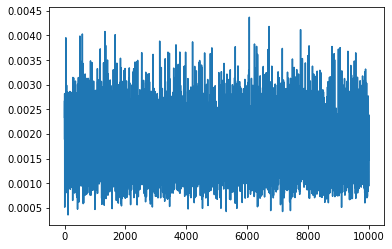

In [5]:
plt.plot(expected_return)

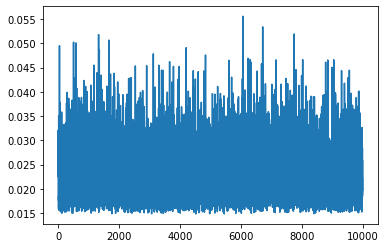

In [6]:
plt.plot(expected_volatility)

### 3. Maximize Sharpe Ratio: Efficient Frontier and Tangency Portfolio

In [7]:
# find out the portfolio with max Sharpe Ratio
maxIndex = SharpeRatio.argmax()
print('optimal weights for',stock_pool,':',weight[maxIndex,:])
print('daily return, daily volatility, daily sharpe ratio:', 
      expected_return[maxIndex], expected_volatility[maxIndex], SharpeRatio[maxIndex])
print('annualized return, annualized volatility, annualized sharpe ratio:',
      expected_return[maxIndex]*252, expected_volatility[maxIndex]*np.sqrt(252),
      (expected_return[maxIndex]*252-Annual_RiskfreeRate)/(expected_volatility[maxIndex]*np.sqrt(252)))

optimal weights for ['AAPL', 'KR', 'LAC', 'V'] : [0.35012739 0.39344888 0.25127113 0.0051526 ]
daily return, daily volatility, daily sharpe ratio: 0.0020368427455175497 0.02208082941469731 0.08946816178089685
annualized return, annualized volatility, annualized sharpe ratio: 0.5132843718704225 0.35052230023997394 1.419922132000384


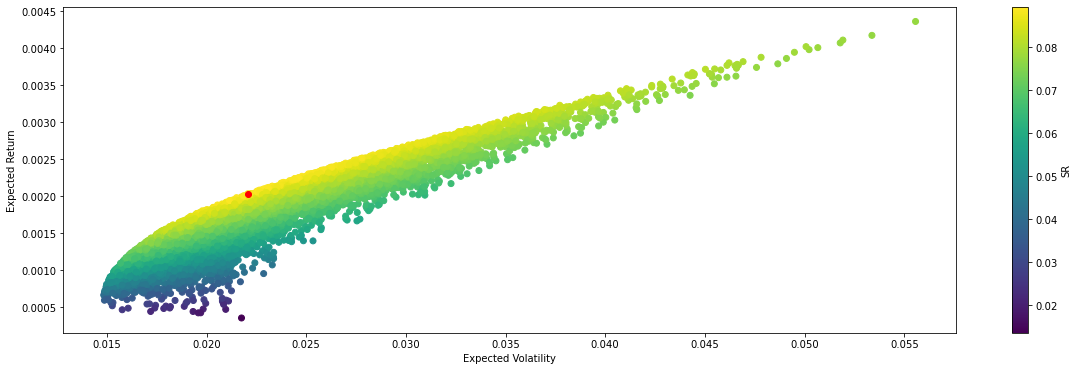

In [8]:
# plot return vs volatility chart
plt.figure(figsize=(20,6))
plt.scatter(expected_volatility, expected_return, c=SharpeRatio)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='SR')

# plot tangency portfolio
plt.scatter(expected_volatility[maxIndex], expected_return[maxIndex], c='red')
plt.show()

In [9]:
# find out the optimized volatility for a given expected_return datapoint
# an optimization problem minimizing the volatility subject to a box constraints on the weights sum to one and minimum accepted return equals to the return using for grid search 

# create evenly spaced numbers starting from expected_return.min() to expected_return.max() for grid search
returns = np.linspace(expected_return.min(), expected_return.max(), 50)
optimized_volatility = []

def MinimizeVol(w):
    w = np.array(w)
    Vol = np.sqrt(np.dot(w.T, np.dot(sigma_logreturns,w)))
    return Vol

def checkSumToOne(w):
    return np.sum(w)-1

def getReturn(w):
    w = np.array(w)
    Ret = np.sum(mean_logreturns*w)
    return Ret

for R in returns:
    w0 = [1/len(stock_pool)]*len(stock_pool)
    bounds = [(0,1)]*len(stock_pool)
    constraints = ({'type':'eq', 'fun':checkSumToOne},
                   {'type':'eq', 'fun':lambda w: getReturn(w)-R})
    optimized_vol = minimize(MinimizeVol, w0, method='SLSQP', bounds=bounds, constraints=constraints)
    optimized_volatility.append(optimized_vol['fun'])

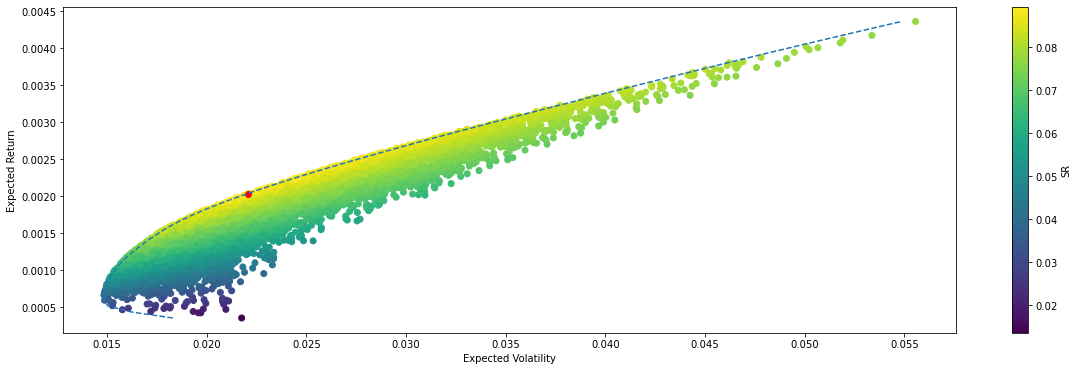

In [10]:
# plot Efficient Frontier
plt.figure(figsize=(20,6))
plt.scatter(expected_volatility, expected_return, c=SharpeRatio)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='SR')
plt.scatter(expected_volatility[maxIndex], expected_return[maxIndex], c='red')
plt.plot(optimized_volatility, returns, '--')
plt.show()

## II Portfolio Performance and Exposure to Fama-French 3 Factors (Market, Size, Value)

### 1 Prepare Data for Fama-French Three-Factor Model Analysis

In [11]:
# get fama_french data from Kenneth French's website at Dartmouth
def get_fama_french():
    ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip"
    urllib.request.urlretrieve(ff_url,'fama_french.zip')
    zip_file = zipfile.ZipFile('fama_french.zip', 'r')
    zip_file.extractall()
    zip_file.close()
    ff_factors = pd.read_csv('F-F_Research_Data_Factors_daily.csv', skiprows = 3, skipfooter=1, index_col = 0, engine='python')
    
    # Format the date index
    ff_factors.index = pd.to_datetime(ff_factors.index, format= '%Y%m%d') 
    
    # Convert from percent to decimal
    ff_factors = ff_factors.apply(lambda x: x/100)
    return ff_factors

FamaFrenchData = get_fama_french()
FamaFrenchData = FamaFrenchData.loc[start:end,:]
# check the beginning and end of dataset
FamaFrenchData.iloc[np.r_[0:5,-5:0]]

,Mkt-RF,SMB,HML,RF
2020-01-02,0.0086,-0.0089,-0.0032,0.00006
2020-01-03,-0.0067,0.0039,0.0000,0.00006
2020-01-06,0.0036,-0.0007,-0.0054,0.00006
2020-01-07,-0.0019,-0.0001,-0.0025,0.00006
2020-01-08,0.0047,-0.0006,-0.0065,0.00006
2021-10-25,0.0058,0.0049,-0.0016,0.00000
2021-10-26,0.0004,-0.0071,-0.0032,0.00000
2021-10-27,-0.0076,-0.0074,-0.0119,0.00000
2021-10-28,0.0114,0.0087,-0.0047,0.00000
2021-10-29,0.0022,0.0019,-0.0082,0.00000


In [12]:
# prepare data for Fama-French Three Factot Model analysis
FFModel_Data = pd.concat([logreturns,FamaFrenchData], axis=1)

# Calculate portfolio return and portfolio excess return
tangency_portfolio_weights = weight[maxIndex,:]
FFModel_Data['Portfolio_Return'] = logreturns.mul(tangency_portfolio_weights, axis=1).sum(axis=1)
FFModel_Data['Portfolio_Excess'] = FFModel_Data['Portfolio_Return'] - FFModel_Data['RF']

# drop the first row due to nan values in stock logreturns
FFModel_Data = FFModel_Data.dropna()

# rename the column for market excess return
FFModel_Data.rename(columns={"Mkt-RF": "Market_Excess"}, inplace=True)

### 2 Run Regression on Portfolio_Excess with Market_Excess, SMB and HML

In [13]:
# define the regression formula
FamaFrench_model = smf.ols(formula='Portfolio_Excess ~ Market_Excess + SMB + HML' , data=FFModel_Data)

# fit the regression
FamaFrench_fit = FamaFrench_model.fit()
print(FamaFrench_fit.summary())

                            OLS Regression Results                            
Dep. Variable:       Portfolio_Excess   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     168.3
Date:                Wed, 15 Dec 2021   Prob (F-statistic):           1.73e-73
Time:                        10:54:49   Log-Likelihood:                 1275.7
No. Observations:                 461   AIC:                            -2543.
Df Residuals:                     457   BIC:                            -2527.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0009      0.001      1.273

## III Tangency Portfolio Performance and Risk

### 1 Tracking Error, Tracking Error Volatility, and Information Ratio

In [14]:
# set S&P 500 as benchmark
benchmark = getdata('SPY')
benchmark = benchmark[['Adj Close']]
Benchmark_return = benchmark/benchmark.shift(1)
Benchmark_return = Benchmark_return.dropna()
Benchmark_Return = np.log(Benchmark_return).squeeze()

Portfolio_Return = FFModel_Data['Portfolio_Return']

# calculate correlation, TE, TEV, and IR
correlation = Portfolio_Return.corr(Benchmark_Return) 
TE = Portfolio_Return.mean() - Benchmark_Return.mean()
TEV = (Portfolio_Return.var() + Benchmark_Return.var() - 2*correlation*Portfolio_Return.std()*Benchmark_Return.std())**0.5
IR = TE/TEV

print('TE: ', TE, '\nTEV: ', TEV, '\nIR: ', IR)

TE:  0.001224680469507895 
TEV:  0.01630295578805708 
IR:  0.07512014909621781


### 2 Portfolio Maximum Drawdown

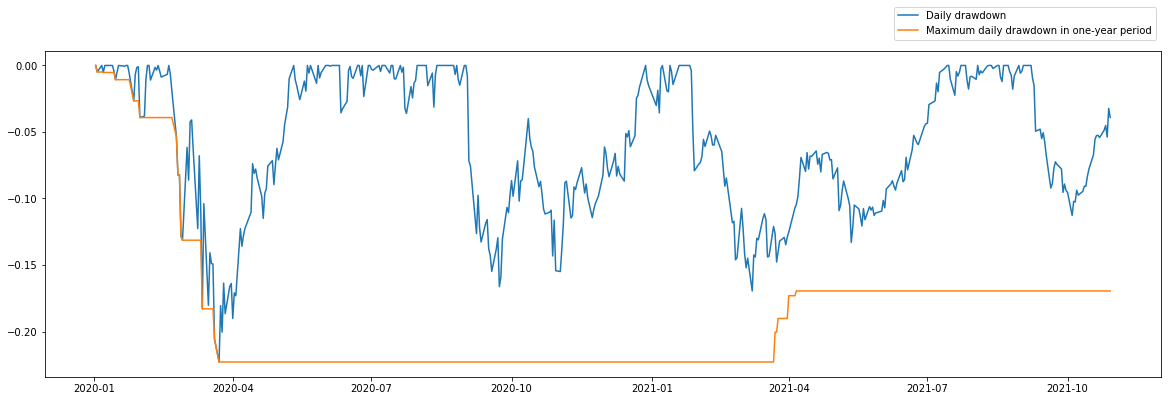

In [15]:
# calculate the max portfolio value
Portfolio_Value = stocks.mul(tangency_portfolio_weights, axis=1).sum(axis=1)
roll_max = Portfolio_Value.rolling(center=False, min_periods=1, window=252).max()

# calculate the daily draw-down relative to the max
daily_draw_down = Portfolio_Value/roll_max - 1

# calculate the minimum (negative) daily draw-down
max_daily_draw_down = daily_draw_down.rolling(center=False,min_periods=1,window=252).min()

# plot the results
plt.figure(figsize=(20,6))
plt.plot(daily_draw_down, label='Daily drawdown')
plt.plot(max_daily_draw_down, label='Maximum daily drawdown in one-year period')
plt.legend(bbox_to_anchor =(1.00, 1.15), ncol = 1, loc='upper right')
plt.show()

### 3 Portfolio Value at Risk and Expected Shortfall at 95% Confidence Level

VaR(95) is:  -0.03441568075038172
CVaR(95) is:  -0.05120659378043132


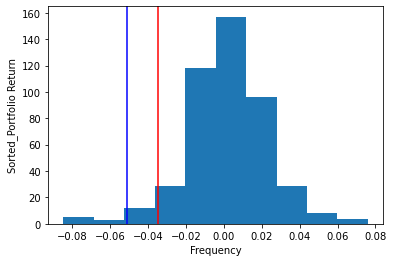

In [16]:
# calculate historical VaR(95)
Portfolio_Return = FFModel_Data['Portfolio_Return']
var_95 = np.percentile(Portfolio_Return, 100-95)
print('VaR(95) is: ', var_95)

# historical CVaR(95)
cvar_95 = Portfolio_Return[Portfolio_Return <= var_95].mean()
print('CVaR(95) is: ', cvar_95)

# sort the returns for plotting
sorted_rets = Portfolio_Return.sort_values()

# plot the probability of each sorted return quantile
plt.hist(sorted_rets)
plt.xlabel('Frequency')
plt.ylabel('Sorted_Portfolio Return')

# denote the VaR 95 quantile
plt.axvline(x=var_95, color='r', linestyle='-', label="VaR 95: {0:.2f}%".format(var_95))
plt.axvline(x=cvar_95, color='b', linestyle='-', label='CVaR 95: {0:.2f}%'.format(cvar_95))
plt.show()

### 4 Forecast Portfolio VaR at 95% Confidence Level Using Parametric Approach

In [17]:
# set the simulation parameters
mu = np.mean(Portfolio_Return)
vol = np.std(Portfolio_Return)

# set the VaR confidence level
significance_level = 0.05

# calculate Parametric VaR
var_95 = norm.ppf(significance_level, mu, vol)
print('VaR(95): ', var_95)

VaR(95):  -0.034243475883270855


### 5 Forecast Portfolio VaR at 95% Confidence Level Using Mente Carlo Simulation

In [18]:
# set the simulation parameters
# for simplicity, assume return~normal(mu,vol) 
mu = np.mean(Portfolio_Return)
vol = np.std(Portfolio_Return)
T = 252

# aggregate the returns
sim_returns = []

# loop through 100 simulations
for i in range(100):
    # generate the Random Walk
    rand_rets = np.random.normal(mu, vol, T)   
    # save the results
    sim_returns.append(rand_rets)

# calculate the VaR(95)
var_95 = np.percentile(sim_returns, 100-95)
print('VaR(95): ', var_95)

VaR(95):  -0.034757415253835695
